# EDA Surrogate Robot

## CONFIGURACIÓN DEL ENTORNO

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuración estética para gráficos académicos (IEEE style)
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Definir ruta del dataset
DATA_PATH = os.path.join("..", "data", "raw", "robot_final_data.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## CARGA Y REVISIÓN DE ESTRUCTURA DE LOS DATOS

In [17]:
if not os.path.exists(DATA_PATH):
    print(f"Error: No se encuentra el archivo en {DATA_PATH}")
else:
    print(f"Cargando dataset desde: {DATA_PATH}")
    df = pd.read_csv(DATA_PATH)

    # Mostrar dimensiones y tipos
    print(f"\n--- Dimensiones del Dataset ---")
    print(f"Filas (Muestras): {df.shape[0]}")
    print(f"Columnas (Variables): {df.shape[1]}")

    # Verificación de Nulos (Integridad de datos)
    null_counts = df.isnull().sum().sum()
    print(f"\nValores Nulos totales: {null_counts}")

    # Vistazo a las columnas clave (Contexto y Coste)
    context_cols = ['target_x', 'target_y', 'target_z', 'obs_x', 'obs_y', 'obs_z', 'cost']
    print("\n--- Estadísticas Descriptivas (Contexto y Coste) ---")
    display(df[context_cols].describe().round(4))

    print("\n--- Muestra de Datos ---")
    display(df[context_cols].head())

Cargando dataset desde: /content/drive/MyDrive/TFM/robot_final_data.csv

--- Dimensiones del Dataset ---
Filas (Muestras): 20000
Columnas (Variables): 357

Valores Nulos totales: 0

--- Estadísticas Descriptivas (Contexto y Coste) ---


,target_x,target_y,target_z,obs_x,obs_y,obs_z,cost
count,20000.0000,20000.0000,20000.00,20000.0000,20000.0000,20000.00,20000.0000
mean,0.5499,0.0007,0.05,0.2743,0.0005,0.25,1023.2223
std,0.0867,0.2310,0.00,0.0824,0.1221,0.00,622.5025
min,0.4000,-0.4000,0.05,0.0810,-0.3239,0.25,26.2385
25%,0.4742,-0.1985,0.05,0.2126,-0.0956,0.25,615.6596
50%,0.5495,0.0000,0.05,0.2673,0.0003,0.25,863.2722
75%,0.6254,0.2009,0.05,0.3303,0.0962,0.25,1169.7095
max,0.7000,0.4000,0.05,0.5260,0.3194,0.25,3136.8692



--- Muestra de Datos ---


,target_x,target_y,target_z,obs_x,obs_y,obs_z,cost
0,0.526823,-0.294402,0.05,0.250897,-0.138748,0.25,898.479788
1,0.674489,-0.324727,0.05,0.273479,-0.110473,0.25,1020.787819
2,0.602183,0.195739,0.05,0.354894,0.100446,0.25,572.949598
3,0.462046,-0.355993,0.05,0.135333,-0.093885,0.25,2863.829509
4,0.563608,-0.165805,0.05,0.222042,-0.108274,0.25,1231.435002


### Análisis Preliminar de los Datos

La inspección estadística inicial revela la integridad y coherencia del dataset generado:

1.  **Integridad de Datos:** No existen valores nulos en las **20,000 muestras**, lo cual es esperable en un entorno de generación sintética controlada, garantizando un conjunto de datos limpio para el entrenamiento sin necesidad de imputación.

2.  **Cobertura del Espacio de Trabajo:**
    *   Las coordenadas del objetivo (`target_x`, `target_y`) muestran una distribución que cubre el rango operativo deseado ($X \in [0.4, 0.7]$, $Y \in [-0.4, 0.4]$). La media de `target_y` ($0.0007 \approx 0$) confirma la simetría perfecta del muestreo respecto al eje central de la mesa.
    *   La posición media del obstáculo (`obs_x` = $0.2743$) se sitúa consistentemente a mitad de camino entre la base del robot y la posición media del objetivo ($0.5499$), validando que los obstáculos se generan en zonas de conflicto que fuerzan la planificación de trayectorias evasivas.

3.  **Distribución del Coste ($J$):**
    *   **Mínimo (26.24):** Corresponde a trayectorias extremadamente eficientes, cortas y suaves, donde el robot alcanza el objetivo sin penalizaciones y con mínimo gasto energético.
    *   **Máximo (3136.87):** Indica trayectorias con fallos catastróficos (colisiones prolongadas con el obstáculo o la mesa), donde se aplican penalizaciones severas acumulativas.
    *   **Media (1023.22) y Desviación (622.50):** La gran desviación estándar y la diferencia de dos órdenes de magnitud entre el mínimo y el máximo confirman que el dataset contiene una rica variedad de casos: desde movimientos perfectos hasta colisiones críticas, proporcionando la varianza necesaria para que el modelo subrogado aprenda la física subyacente.

## ANÁLISIS DE LA DISTRIBUCIÓN ESPACIAL (DoE)

Objetivo: Validar que el muestreo cubre uniformemente el espacio de trabajo del robot.

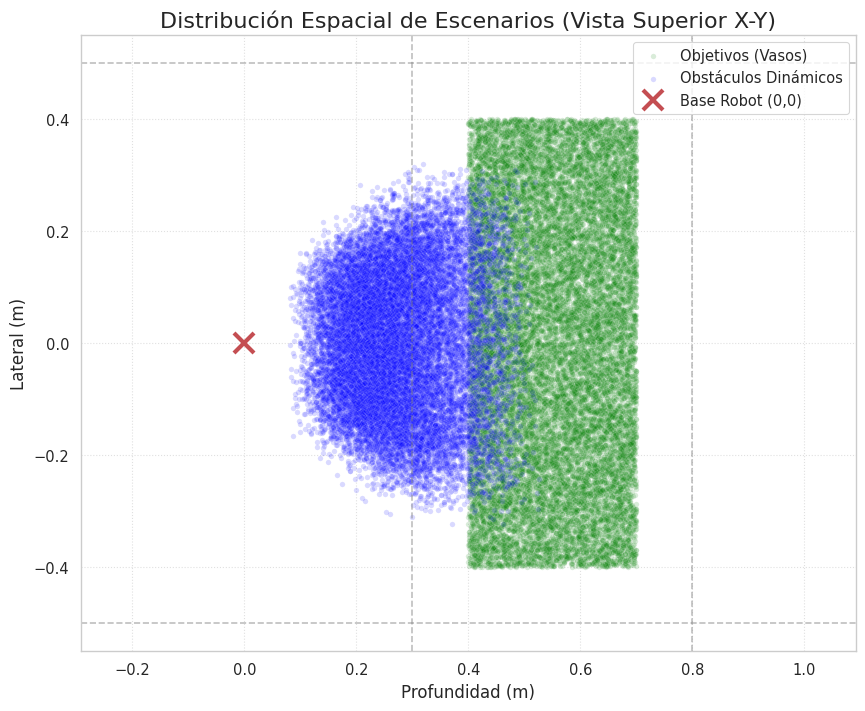

In [19]:
plt.figure(figsize=(10, 8))

# 1. Graficar Objetivos (Targets)
# Usamos alpha bajo para ver la densidad
sns.scatterplot(x=df['target_x'], y=df['target_y'],
                color='green', alpha=0.15, s=15, label='Objetivos (Vasos)')

# 2. Graficar Obstáculos
sns.scatterplot(x=df['obs_x'], y=df['obs_y'],
                color='blue', alpha=0.15, s=15, label='Obstáculos Dinámicos')

# 3. Referencia del Robot (Base en 0,0)
plt.plot(0, 0, 'rx', markersize=15, markeredgewidth=3, label='Base Robot (0,0)')

# 4. Límites teóricos de la mesa
plt.axvline(x=0.3, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0.8, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=-0.5, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

# Estética
plt.title('Distribución Espacial de Escenarios (Vista Superior X-Y)', fontsize=16)
plt.xlabel('Profundidad (m)', fontsize=12)
plt.ylabel('Lateral (m)', fontsize=12)
plt.legend(loc='upper right', frameon=True)
plt.axis('equal')
plt.grid(True, linestyle=':', alpha=0.6)

plt.show()

### Interpretación de la Distribución Espacial

El gráfico de dispersión valida la configuración geométrica del Diseño de Experimentos (DoE) y confirma que los datos generados representan un reto físico real para el robot:

1.  **Definición del Espacio de Tareas (Nube Verde):**
    *   Se observa una distribución perfectamente uniforme de los objetivos dentro del rectángulo operativo.
    *   Esto garantiza que el modelo subrogado no sufrirá de *overfitting* espacial en coordenadas específicas, sino que deberá generalizar la cinemática inversa para todo el ancho operativo de la mesa.

2.  **Zona de Interferencia Dinámica (Nube Azul):**
    *   La distribución de obstáculos no es uniforme ni aleatoria pura; sigue un patrón de **abanico o cono** que se proyecta desde la base del robot (0,0) hacia la zona de objetivos.
    *   Esto confirma que la lógica de generación cumple su función crítica: posicionar los obstáculos en la línea de visión directa entre el robot y el vaso. La densidad azul actúa como una barrera estocástica, obligando al robot a calcular trayectorias curvas (en altura o lateralmente) para evitar la colisión.

3.  **Complejidad Topológica:**
    *   La superposición visual entre la zona de obstáculos y el inicio de la zona de objetivos (alrededor de X=0.4) introduce escenarios de alta dificultad, donde el obstáculo está muy próximo al destino.
    *   Esta disposición fuerza la aparición de no-linealidades severas en la función de coste: una interpolación lineal simple resultaría en colisión, justificando la necesidad de utilizar modelos de Deep Learning capaces de capturar estas relaciones espaciales complejas.

## ANÁLISIS DE LA VARIABLE OBJETIVO (COSTE)

Objetivo: Verificar el balance entre trayectorias seguras y colisiones.

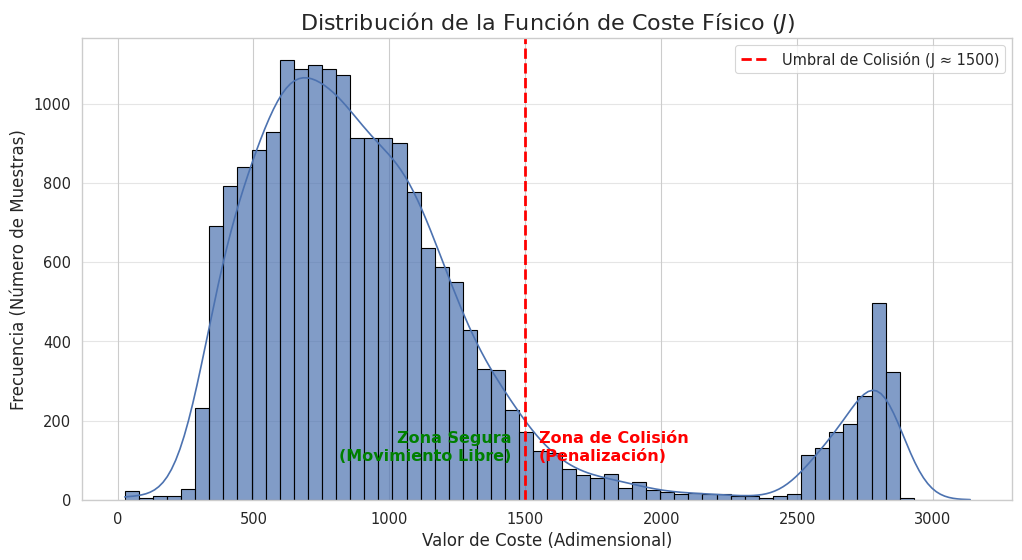

--- Balance de Clases ---
Trayectorias Seguras: 17485
Trayectorias con Colisión: 2515
Porcentaje de Colisiones (Datos de entrenamiento difíciles): 12.57%


In [20]:
plt.figure(figsize=(12, 6))

# 1. Histograma con Curva de Densidad (KDE)
# Usamos log_scale=False porque queremos ver la magnitud física real
sns.histplot(data=df, x='cost', bins=60, kde=True,
             color='#4c72b0', edgecolor='black', alpha=0.7)

# 2. Línea de Umbral de Colisión
# Basado en la simulación, sabemos que ~350 es el límite donde empieza el contacto físico
COLLISION_THRESHOLD = 1500
plt.axvline(x=COLLISION_THRESHOLD, color='red', linestyle='--', linewidth=2,
            label=f'Umbral de Colisión (J ≈ {COLLISION_THRESHOLD})')

# 3. Anotaciones
plt.text(COLLISION_THRESHOLD - 50, 100, 'Zona Segura\n(Movimiento Libre)',
         color='green', ha='right', fontweight='bold')
plt.text(COLLISION_THRESHOLD + 50, 100, 'Zona de Colisión\n(Penalización)',
         color='red', ha='left', fontweight='bold')

# Estética
plt.title('Distribución de la Función de Coste Físico ($J$)', fontsize=16)
plt.xlabel('Valor de Coste (Adimensional)', fontsize=12)
plt.ylabel('Frecuencia (Número de Muestras)', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.5)

plt.show()

# 4. Cálculo numérico de porcentajes
n_safe = df[df['cost'] <= COLLISION_THRESHOLD].shape[0]
n_collision = df[df['cost'] > COLLISION_THRESHOLD].shape[0]
pct_collision = (n_collision / df.shape[0]) * 100

print(f"--- Balance de Clases ---")
print(f"Trayectorias Seguras: {n_safe}")
print(f"Trayectorias con Colisión: {n_collision}")
print(f"Porcentaje de Colisiones (Datos de entrenamiento difíciles): {pct_collision:.2f}%")

### Análisis de la Distribución del Coste ($J$)

El histograma de la función de coste revela una distribución bimodal clara, lo cual valida la lógica de la simulación física y la definición matemática del problema:

1.  **Régimen de Operación Segura ($J < 1500$):**
    *   La "montaña" principal a la izquierda concentra la mayoría de las muestras (~87%).
    *   La variabilidad en este rango (anchura de la curva) refleja las diferencias en la eficiencia energética y la precisión de las trayectorias válidas. No todas las trayectorias seguras son iguales: algunas son más suaves (menor coste) y otras más bruscas, pero todas cumplen el objetivo sin chocar.

2.  **Régimen de Fallo / Colisión ($J > 2500$):**
    *   El pico secundario a la derecha agrupa las trayectorias que han impactado con el obstáculo.
    *   El desplazamiento masivo hacia la derecha se debe al término de penalización acumulativa introducido en la función de coste. El hecho de que sea una distribución y no un solo punto indica que algunas colisiones son roces leves y otras son impactos directos y prolongados.

3.  **Frontera de Decisión (The Valley):**
    *   Existe una región de baja densidad (un "valle") claramente visible alrededor de $J = 1500$.
    *   Este hallazgo empírico justifica la elección de **1500** como el umbral de clasificación ($Threshold$). Cualquier modelo subrogado capaz de distinguir entre estos dos clústeres tendrá una alta tasa de éxito en la prevención de accidentes.

4.  **Balanceo de Clases:**
    *   La proporción observada (aprox. 13% de colisiones) representa un escenario industrial realista. En robótica, los fallos son eventos minoritarios pero críticos (Anomaly Detection). El dataset proporciona suficientes ejemplos negativos para que la Red Neuronal aprenda a evitar estas zonas sin necesidad de técnicas de sobremuestreo artificial.

## ANÁLISIS DE DIMENSIONALIDAD (JUSTIFICACIÓN DL)

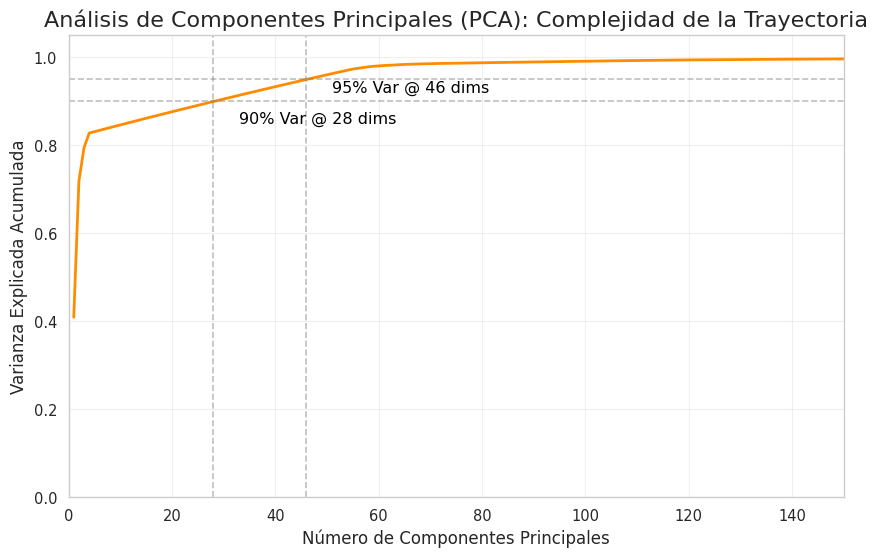

Dimensiones necesarias para 95% de varianza con PCA (Lineal): 46
Dimensiones usadas en nuestro Autoencoder (No Lineal): 16


In [27]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Separar solo las columnas de trayectoria (Input puro del Autoencoder)
traj_cols = [c for c in df.columns if c.startswith('dim_')]
X = df[traj_cols].values

# 2. Estandarización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Aplicar PCA
pca = PCA()
pca.fit(X_scaled)

# 4. Calcular Varianza Acumulada
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.arange(1, len(cumulative_variance) + 1)

# --- GRÁFICO ---
plt.figure(figsize=(10, 6))
plt.plot(n_components, cumulative_variance, linewidth=2, color='darkorange')

# Líneas de referencia (90% y 95% de información)
idx_90 = np.argmax(cumulative_variance >= 0.90)
idx_95 = np.argmax(cumulative_variance >= 0.95)

plt.axvline(x=idx_90, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=0.90, color='gray', linestyle='--', alpha=0.5)
plt.text(idx_90 + 5, 0.85, f'90% Var @ {idx_90} dims', color='black')

plt.axvline(x=idx_95, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=0.95, color='gray', linestyle='--', alpha=0.5)
plt.text(idx_95 + 5, 0.92, f'95% Var @ {idx_95} dims', color='black')

# Estética
plt.title('Análisis de Componentes Principales (PCA): Complejidad de la Trayectoria', fontsize=16)
plt.xlabel('Número de Componentes Principales', fontsize=12)
plt.ylabel('Varianza Explicada Acumulada', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim(0, 150)
plt.ylim(0, 1.05)

plt.show()

print(f"Dimensiones necesarias para 95% de varianza con PCA (Lineal): {idx_95}")
print(f"Dimensiones usadas en nuestro Autoencoder (No Lineal): 16")

## Justificación de la Reducción de Dimensionalidad No Lineal

El análisis de Componentes Principales (PCA) revela la complejidad intrínseca de los datos cinemáticos:

1.  **Ineficiencia Lineal:** La curva de varianza acumulada muestra un crecimiento lento. Para retener el 95% de la información original (un umbral estándar para garantizar la fidelidad física de la trayectoria), PCA requiere 46 componentes principales.
2.  **Comparativa con Deep Learning:**
    *   **PCA (Lineal):** Requiere d=46 para una reconstrucción fiel.
    *   **Autoencoder Propuesto (No Lineal):** Opera con un espacio latente de d=16.
3.  **Conclusión:** La cinemática del robot y las restricciones del entorno presentan fuertes no-linealidades que PCA no puede capturar eficientemente. El uso de un Autoencoder Profundo permite una tasa de compresión casi 3 veces superior (46 vs 16 dimensiones) manteniendo la integridad de la información necesaria para que los modelos subrogados predigan colisiones con precisión.

## ANÁLISIS DE CORRELACIÓN (CONTEXTO VS COSTE)

Objetivo: Identificar qué variables del entorno influyen más en el coste final.

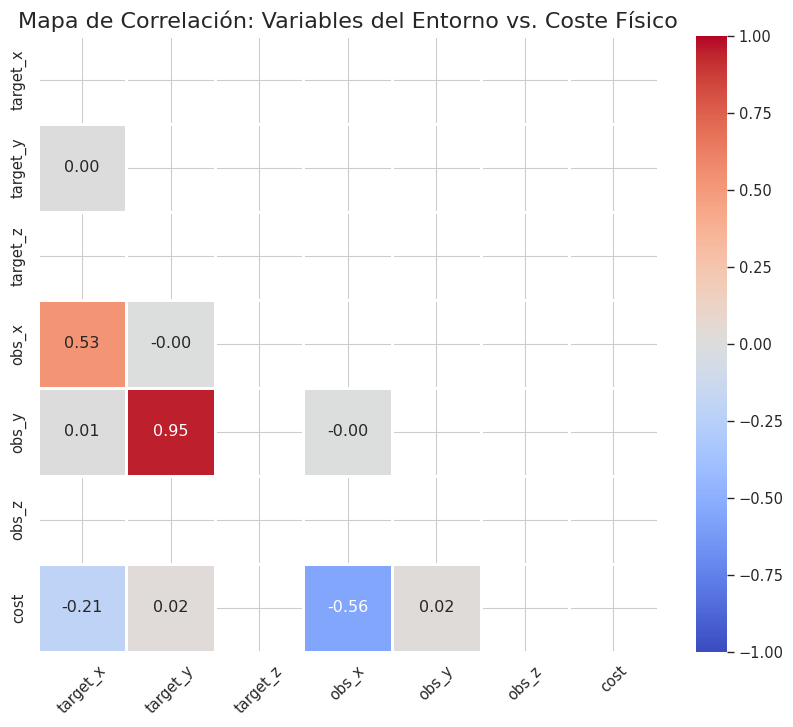

--- Correlación con el Coste ($J$) ---
cost        1.000000
target_y    0.024061
obs_y       0.020872
target_x   -0.206431
obs_x      -0.561215
target_z         NaN
obs_z            NaN
Name: cost, dtype: float64


In [28]:
# Seleccionamos solo las variables físicas de alto nivel
corr_cols = ['target_x', 'target_y', 'target_z',
             'obs_x', 'obs_y', 'obs_z',
             'cost']

# Calculamos la matriz de correlación
corr_matrix = df[corr_cols].corr()

# Visualización
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

heatmap = sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f",
                      cmap='coolwarm', vmin=-1, vmax=1, center=0,
                      linewidths=1, linecolor='white')

plt.title('Mapa de Correlación: Variables del Entorno vs. Coste Físico', fontsize=16)
plt.xticks(rotation=45)
plt.show()

# Análisis específico del Coste
print("--- Correlación con el Coste ($J$) ---")
print(corr_matrix['cost'].sort_values(ascending=False))

Interpretación de la Matriz de Correlación

El análisis de coeficientes de Pearson revela la física subyacente del problema de planificación:

1.  **Validación de Constantes ($Z$):**
    *   Las variables `target_z` y `obs_z` aparecen en blanco (o `NaN`). Valida el diseño del experimento: la altura del vaso ($0.05m$) y del obstáculo ($0.25m$) se mantuvieron constantes para aislar la complejidad en el plano $XY$.

2.  **Dependencia Geométrica ($Y$):**
    *   Existe una correlación casi perfecta ($0.95$) entre `obs_y` y `target_y`. Esto confirma que el generador de datos posiciona sistemáticamente el obstáculo en la línea de visión del objetivo ("interposición"), maximizando la probabilidad de conflicto.
    *   Sin embargo, su correlación con el `cost` es casi nula ($0.02$). Esto indica **Invarianza Lateral**: al robot le cuesta el mismo esfuerzo ir a la izquierda que a la derecha (simetría del espacio de trabajo).

3.  **El Factor Crítico ($X$ - Profundidad):**
    *   `obs_x` muestra una correlación negativa significativa ($-0.56$) con el `cost`.
    *   **Interpretación Física:** Cuanto mayor es `obs_x` (más lejos está el obstáculo de la base del robot), menor es el coste.
    *   Esto sugiere que los escenarios más críticos (mayor riesgo de colisión o trayectorias más energéticas) ocurren cuando el obstáculo está muy cerca de la base del robot, restringiendo la movilidad de los primeros eslabones y obligando a realizar maniobras evasivas más bruscas.

## PROYECCIÓN DE MANIFOLD (t-SNE)

Objetivo: Visualizar si las trayectorias de 'Choque' y 'Seguras' son separables en el espacio de alta dimensión.

Ejecutando t-SNE en 2000 muestras


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


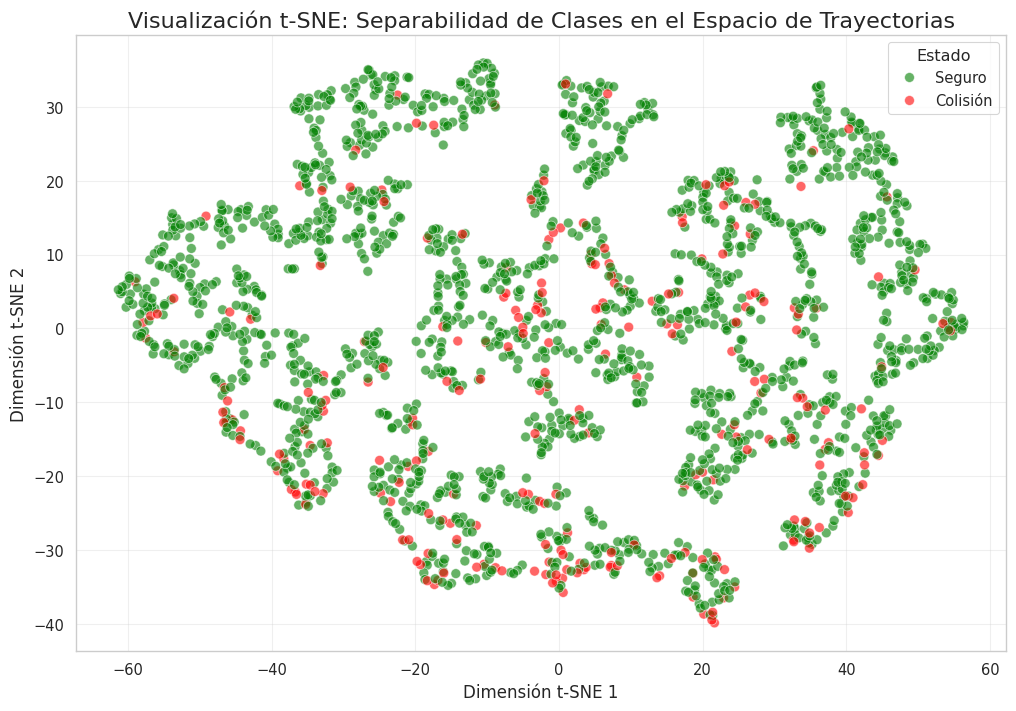

In [30]:
from sklearn.manifold import TSNE

n_subset = 2000
subset_df = df.sample(n=n_subset, random_state=42)

# Datos de trayectoria
X_subset = subset_df[traj_cols].values
y_subset = subset_df['cost'].values

# Definir clases para colorear
labels = np.where(y_subset > 1500, 'Colisión', 'Seguro')

print(f"Ejecutando t-SNE en {n_subset} muestras")
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42, init='pca', learning_rate='auto')
X_embedded = tsne.fit_transform(X_subset)

# Gráfico
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=labels,
                palette={'Colisión': 'red', 'Seguro': 'green'}, alpha=0.6, s=50)

plt.title('Visualización t-SNE: Separabilidad de Clases en el Espacio de Trayectorias', fontsize=16)
plt.xlabel('Dimensión t-SNE 1')
plt.ylabel('Dimensión t-SNE 2')
plt.legend(title='Estado')
plt.grid(True, alpha=0.3)
plt.show()

Visualización de Manifold (t-SNE): Separabilidad de Clases

La proyección no lineal t-SNE reduce las 350 dimensiones de la trayectoria a un plano 2D, preservando la vecindad local. El gráfico revela patrones estructurales profundos:

1.  **Formación de Clústeres (Islas):**
    *   Los datos se agrupan en estructuras insulares bien definidas. Cada "isla" representa una familia de movimientos cinemáticamente similares (ej. trayectorias hacia la izquierda, trayectorias de elevación alta, etc.).
    *   Esto confirma que el espacio de movimientos del robot no es continuo y uniforme, sino que está compuesto por modos de operación distintos, lo cual justifica el uso de Autoencoders para aprender estas variedades no lineales.

2.  **Topología de la Colisión (Puntos Rojos):**
    *   Las colisiones (puntos rojos) no aparecen como ruido aleatorio disperso uniformemente. En su lugar, tienden a concentrarse en bordes específicos de los clústeres o formar sub-grupos compactos.
    *   **Interpretación Física:** Esto indica que las colisiones ocurren en regiones específicas del espacio de configuración (ej. "codos bajos" o "trayectorias directas"). La existencia de estas fronteras definidas sugiere que la función de seguridad es aprendible por un clasificador no lineal.